Import Thư viện

In [83]:
import keras
from tensorflow import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt   
import numpy as np                
import os                         
from scipy.io import loadmat, savemat     
from scipy import signal        
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import math


Đặt kênh EEG

In [27]:
REPETITIONS = 15
SAMPLING_FREQUENCY = 240  

In [28]:
def load_mydata(file_path):
  
  if not os.path.exists(file_path):
      print("Missing file: {}", file_path)
  else:
    data = loadmat(file_path)
    signals = data['Signal']
    flashing = data['Flashing']
    word = data['TargetChar']
    stimulusCode = data['StimulusCode'] 
    key = data.keys() 
    if "StimulusType" in key: 
      stimulusType = data['StimulusType']
    else:
      stimulusType = ""  

    RECORDING_DURATION = (len(signals))*(len(signals[0]))/(SAMPLING_FREQUENCY*60)
    TRIALS = len(word[0])
    SAMPLES_PER_TRIAL = len(signals[0])

    print("**********************************")
    print("        DATASET INFORMATION       ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, 
        (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f" % RECORDING_DURATION)
    print("Number of letters:  %d" % TRIALS)
    print("Spelled word:       %s" % word)
    print("File:               %s" % file_path.split("/")[-1])
    return signals, flashing, word, stimulusType, stimulusCode

Load Data

In [29]:
signal_A_TRAIN, flashing_A_TRAIN, word_A_TRAIN, stimulusType_A_TRAIN, _ = load_mydata('Data/Subject_A_Train.mat')
signal_B_TRAIN, flashing_B_TRAIN, word_B_TRAIN, stimulusType_B_TRAIN, _ = load_mydata('Data/Subject_B_Train.mat')
signal_A_TEST, flashing_A_TEST, word_A_TEST, _, stimulusCode_A = load_mydata('Data/Subject_A_Test.mat')
signal_B_TEST, flashing_B_TEST, word_B_TEST, _, stimulusCode_B = load_mydata('Data/Subject_B_Test.mat')
     

**********************************
        DATASET INFORMATION       
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   46.01
Number of letters:  85
Spelled word:       ['EAEVQTDOJG8RBRGONCEDHCTUIDBPUHMEM6OUXOCFOUKWA4VJEFRZROLHYNQDW_EKTLBWXEPOUIKZERYOOTHQI']
File:               Subject_A_Train.mat
**********************************
        DATASET INFORMATION       
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   46.01
Number of letters:  85
Spelled word:       ['VGREAAH8TVRHBYN_UGCOLO4EUERDOOHCIFOMDNU6LQCPKEIREKOYRQIDJXPBKOJDWZEUEWWFOEBHXTQTTZUMO']
File:               Subject_B_Train.mat
**********************************
        DATASET INFORMATION       
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   54.12
Number of letters:  100
Spelled word:       ['WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU']
F

Thiết kế bộ lọc tín hiệu

C:\Users\LOQ\AppData\Local\Temp\ipykernel_9780\2702675753.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(f, 20 * np.log10(abs(h)))


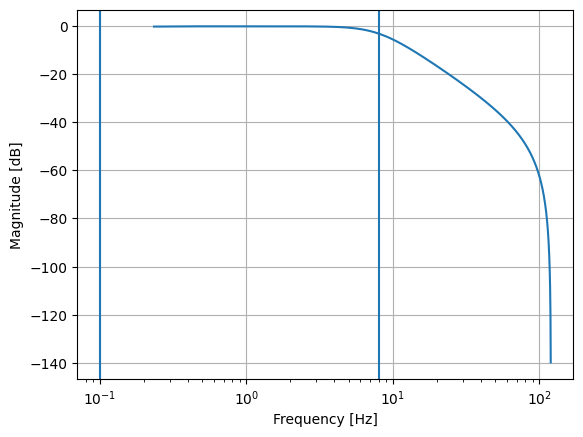

In [30]:
b,a = signal.butter(2, [0.1/(SAMPLING_FREQUENCY/2), 8/(SAMPLING_FREQUENCY/2)], 'bandpass')
f,h = signal.freqz(b,a, fs = SAMPLING_FREQUENCY)
plt.semilogx(f, 20 * np.log10(abs(h))) 
plt.axvline(x=0.1) # f_cut1 [Hz]
plt.axvline(x=8) # f_cut2 [Hz]
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

Xác định P300 và non-P300

In [31]:
def filter_mysignal(sig, flash, stim_type, dataset='train'):
  
  TRIALS = len(sig[:,1,1]) 
  SAMPLES_PER_TRIAL = len(sig[1,:,1])

  epochs = []           
  epoch_labels = []     
  epochDuration = int(SAMPLING_FREQUENCY)  
  y_target = []
  epochs_P300 = []
  epochs_noP300 = []
  window_length = 5 
  polyorder = 2 
  
  
  for trial in range(TRIALS):
    for sample in range(SAMPLES_PER_TRIAL):
      if ( sample == 0 or (flash[trial, sample-1] == 0 and flash[trial, sample] == 1)):
        lower_sample = sample
        upper_sample = sample + epochDuration
        epoch = sig[trial, int(lower_sample):int(upper_sample), :]
        epoch = signal.savgol_filter(epoch, window_length, polyorder, axis=0)
        epoch = signal.filtfilt(b, a, epoch, axis = 0)
        epoch = signal.decimate(epoch, 10, axis=0) 
        
        epoch = (epoch - np.mean(epoch, axis=0, keepdims=True)) / np.std(epoch, axis=0, keepdims=True)
        epochs.append(epoch)

        if dataset == 'train':
          if stim_type[trial, sample] == 1:
            epochs_P300.append(epoch)
            y_target.append(1)
          elif stim_type[trial, sample] == 0:
            epochs_noP300.append(epoch)
            y_target.append(0)
          else: print('Error in finding a class for the {}-th letter'.format(trial))
  
  return np.array(epochs), np.array(y_target).reshape(len(y_target),1), np.array(epochs_P300), np.array(epochs_noP300)

Lọc tín hiệu

In [32]:
print('Filtering signal 1...')
epochs_A_TRAIN, target_A_TRAIN, epochs_A_TRAIN_P300, epochs_A_TRAIN_noP300 = filter_mysignal(signal_A_TRAIN, flashing_A_TRAIN, stimulusType_A_TRAIN)
print('Filtering signal 2...')
epochs_B_TRAIN, target_B_TRAIN, epochs_B_TRAIN_P300, epochs_B_TRAIN_noP300 = filter_mysignal(signal_B_TRAIN, flashing_B_TRAIN, stimulusType_B_TRAIN)
print('Filtering signal 3...')
epochs_A_TEST, _, epochs_A_TEST_P300, epochs_A_TEST_noP300 =  filter_mysignal(signal_A_TEST, flashing_A_TEST, _, dataset='test')
print('Filtering signal 4...')
epochs_B_TEST, _, epochs_B_TEST_P300, epochs_B_TEST_noP300 = filter_mysignal(signal_B_TEST, flashing_B_TEST, _, dataset='test')

Filtering signal 1...
Filtering signal 2...
Filtering signal 3...
Filtering signal 4...


Hàm Matrix channel

In [33]:
def matrixchannel(epoch):
  m = np.zeros((len(epoch[:,0,0]),len(epoch[0,:,0]),10,11))
  m[:,:,0,4:7]=epoch[:,:,21:24] 
  m[:,:,1,3:8]=epoch[:,:,24:29] 
  m[:,:,2,1:10]=epoch[:,:,29:38] 
  m[:,:,3,1]=epoch[:,:,38] 
  m[:,:,3,2:9]=epoch[:,:,0:7] 
  m[:,:,3,9]=epoch[:,:,39] 
  m[:,:,4,1]=epoch[:,:,40] 
  m[:,:,4,2:9]=epoch[:,:,7:14] 
  m[:,:,4,9]=epoch[:,:,41] 
  m[:,:,5,1]=epoch[:,:,44] 
  m[:,:,5,2:9]=epoch[:,:,14:21] 
  m[:,:,5,9]=epoch[:,:,45] 
  m[:,:,4,0]=epoch[:,:,42] 
  m[:,:,6,1:10]=epoch[:,:,46:55] 
  m[:,:,4,10]=epoch[:,:,43] 
  m[:,:,7,3:8]=epoch[:,:,55:60] 
  m[:,:,8,4:7]=epoch[:,:,60:63] 
  m[:,:,9,5]=epoch[:,:,63] 
  return m

Chuyển đổi epoch nhờ Matrix channel

In [34]:
epochs_A_TRAIN_reshaped = matrixchannel(epochs_A_TRAIN)
epochs_A_TEST_reshaped = matrixchannel(epochs_A_TEST)
epochs_B_TRAIN_reshaped = matrixchannel(epochs_B_TRAIN)
epochs_B_TEST_reshaped = matrixchannel(epochs_B_TEST)
epochs_A_TRAIN_P300 = matrixchannel(epochs_A_TRAIN_P300)
epochs_A_TRAIN_noP300 = matrixchannel(epochs_A_TRAIN_noP300)
print(epochs_A_TRAIN_reshaped.shape)

(15300, 24, 10, 11)


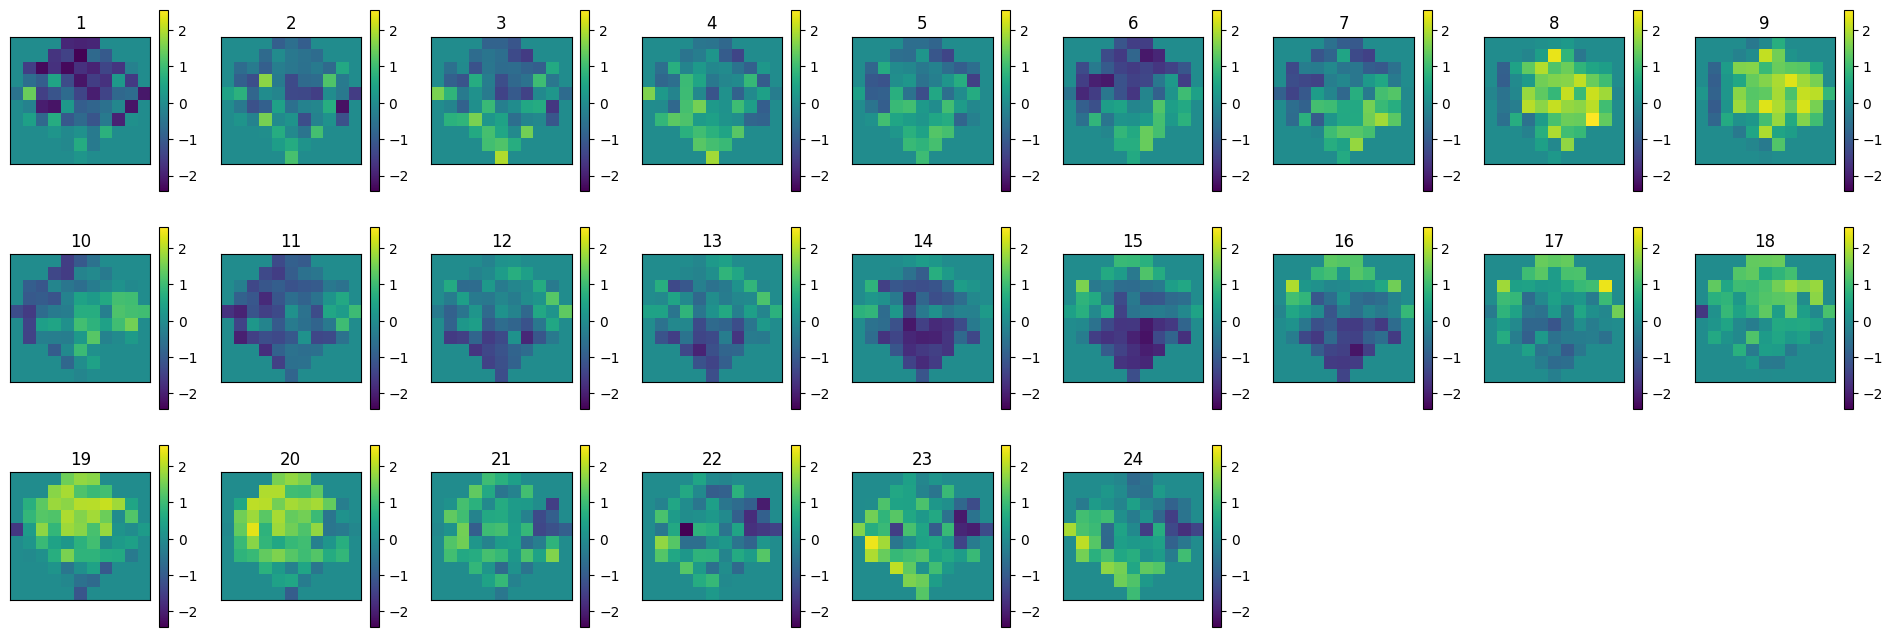

In [35]:
num=10 
maxi=epochs_A_TRAIN_P300[num,:].ravel().max() 
mini=epochs_A_TRAIN_P300[num,:].ravel().min() 

plt.figure(figsize=(24,25))
for i in range(24):
  plt.subplot(9,9,i+1)
  plt.imshow(epochs_A_TRAIN_P300[num,i],  vmin=mini, vmax=maxi) 
  plt.title(str(i+1))
  plt.colorbar()
  plt.xticks([])
  plt.yticks([])
     

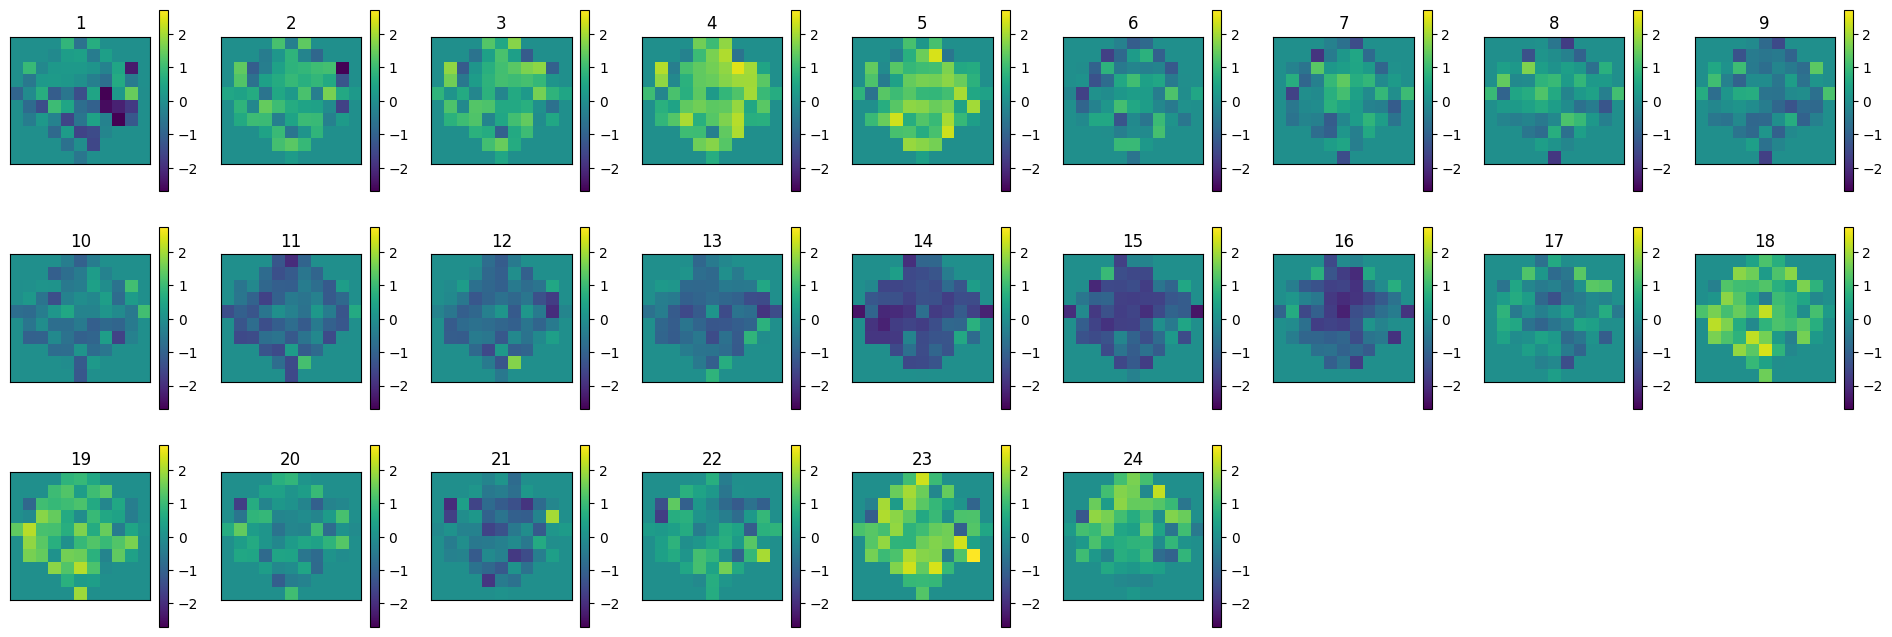

In [36]:
num=10 
maxi=epochs_A_TRAIN_noP300[num,:].ravel().max()
mini=epochs_A_TRAIN_noP300[num,:].ravel().min()

plt.figure(figsize=(24,25))
for i in range(24):
  plt.subplot(9,9,i+1)
  plt.imshow(epochs_A_TRAIN_noP300[num,i],  vmin=mini, vmax=maxi)
  plt.title(str(i+1))
  plt.colorbar()
  plt.xticks([])
  plt.yticks([])

     Chuẩn bị dữ liệu

Thêm chiều cho dữ liệu

In [37]:
epochs_A_TRAIN_reshaped = np.expand_dims(epochs_A_TRAIN_reshaped, axis=4)
epochs_A_TEST_reshaped = np.expand_dims(epochs_A_TEST_reshaped, axis=4)
epochs_B_TRAIN_reshaped = np.expand_dims(epochs_B_TRAIN_reshaped, axis=4)
epochs_B_TEST_reshaped = np.expand_dims(epochs_B_TEST_reshaped, axis=4)

print(epochs_A_TRAIN_reshaped.shape)
print(epochs_A_TEST_reshaped.shape)
print(epochs_B_TRAIN_reshaped.shape)
print(epochs_B_TEST_reshaped.shape)

(15300, 24, 10, 11, 1)
(18000, 24, 10, 11, 1)
(15300, 24, 10, 11, 1)
(18000, 24, 10, 11, 1)


Hàm loại bỏ nhiễu

In [38]:
def stimCode_reduced(stimCode):
  newStimCode = []
  for i in range(len(stimCode[:,0])): 
    index = np.where(np.diff(stimCode[i]) == 0) 
    newTemp_stimcode = np.delete(stimCode[i], index) 
    index = np.where(newTemp_stimcode == 0) 
    newTemp_stimcode = np.delete(newTemp_stimcode, index)
    newStimCode.append(newTemp_stimcode) 

  return np.array(newStimCode) 

In [39]:
stimCode_A_reduced = stimCode_reduced(stimulusCode_A)
stimCode_B_reduced = stimCode_reduced(stimulusCode_B)

In [40]:
MA=[['A','B','C','D','E','F'],
    ['G','H','I','J','K','L'],
    ['M','N','O','P','Q','R'],
    ['S','T','U','V','W','X'],
    ['Y','Z','1','2','3','4'],
    ['5','6','7','8','9','_']]

temp_MA = np.array(MA)

In [41]:
def target_test(stimCode, wordTEST):
  # stimCode is used in its reduced version
  target_TEST = []
 
  for k in range(len(wordTEST)): # for every line/letter in the test set 
    i = np.where(temp_MA == wordTEST[k])[0][0] + 7 
    j = np.where(temp_MA == wordTEST[k])[1][0] + 1
    for sample in range(180): # every time I find a number of columns in stimulusCode corresponding to the letter spelled by the subject
      if (stimCode[k,sample] == i or stimCode[k,sample] == j): # check if the column or the row is the target one
        target_TEST.append(1)
      else:
        target_TEST.append(0)

  return np.array(target_TEST)

In [42]:
target_A_TEST = target_test(stimCode_A_reduced, list(word_A_TEST[0]))
target_B_TEST = target_test(stimCode_B_reduced, list(word_B_TEST[0]))

print(target_A_TEST.shape)
print(target_B_TEST.shape)
print(np.unique(target_A_TEST))

(18000,)
(18000,)
[0 1]


        Thiết kế Network
        

Model A

In [43]:
from tensorflow import keras

modelA = keras.models.Sequential([
        keras.layers.Conv3D(filters=32, input_shape=[24, 10, 11, 1], kernel_size = [4,2,2], strides=(2,1,1),activation = 'elu', padding="SAME", 
                            kernel_regularizer= keras.regularizers.l2(0.02)),
    
        keras.layers.Conv3D(filters=64, kernel_size = [2,2,2], strides=(2,1,1),activation = 'elu', padding="SAME",
                            kernel_regularizer= keras.regularizers.l2(0.02)),

        keras.layers.MaxPool3D(pool_size=(1,2,2)), # Pool stride is the default one (1,1,1)

        keras.layers.Flatten(),
        keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(0.02)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(0.02)),
        keras.layers.Dropout(0.4),

        keras.layers.Dense(units=1, activation='sigmoid')                                 
])

c:\Users\LOQ\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
keras.utils.plot_model( # Show model architecture
    modelA,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=False,
    rankdir='LR', # 'TB' creates a vertical plot; 'LR' creates a horizontal plot.
    expand_nested=True,
    dpi=96
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [45]:
modelA.compile(loss='binary_crossentropy', 
               optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9), 
               metrics=['accuracy'])

In [46]:
class_weight = {0: 1.,1: 5.}

In [47]:
historyA = modelA.fit(epochs_A_TRAIN_reshaped, target_A_TRAIN, epochs=15, batch_size=32, class_weight=class_weight,
                    validation_data =(epochs_A_TEST_reshaped,target_A_TEST))

Epoch 1/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5648 - loss: 3.6068 - val_accuracy: 0.8136 - val_loss: 0.6509
Epoch 2/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6156 - loss: 1.1834 - val_accuracy: 0.5921 - val_loss: 0.7469
Epoch 3/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.6300 - loss: 1.1680 - val_accuracy: 0.7309 - val_loss: 0.6686
Epoch 4/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6364 - loss: 1.1569 - val_accuracy: 0.7508 - val_loss: 0.6260
Epoch 5/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6411 - loss: 1.1547 - val_accuracy: 0.5818 - val_loss: 0.7577
Epoch 6/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6301 - loss: 1.1542 - val_accuracy: 0.7162 - val_loss: 0.6748
Epoch 7/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6488 - loss: 1.1428 - val_accuracy: 0.5868 - val_loss: 0.7532
Epoch 8/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6435 - loss: 1.1405 - 

Model B

In [48]:
from tensorflow import keras

modelB = keras.models.Sequential([
        keras.layers.Conv3D(filters=32, input_shape=[24, 10, 11, 1], kernel_size = [4,2,2], strides=(2,1,1),activation = 'elu', padding="SAME", 
                            kernel_regularizer= keras.regularizers.l2(0.02)),
    
        keras.layers.Conv3D(filters=64, kernel_size = [2,2,2], strides=(2,1,1),activation = 'elu', padding="SAME",
                            kernel_regularizer= keras.regularizers.l2(0.02)),

        keras.layers.MaxPool3D(pool_size=(1,2,2)),
        #keras.layers.BatchNormalization(),

        keras.layers.Flatten(),
        #keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(l=0.02)),
        #keras.layers.Dropout(0.4),
        keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(0.02)),
        keras.layers.Dropout(0.4),

        keras.layers.Dense(units=1, activation='sigmoid')                                 
])

In [49]:
keras.utils.plot_model( # Show model architecture
    modelB,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=False,
    rankdir='LR', # 'TB' creates a vertical plot; 'LR' creates a horizontal plot.
    expand_nested=True,
    dpi=96
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [51]:
modelB.compile(loss='binary_crossentropy', 
               optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9), 
               metrics=['accuracy'])
     

In [52]:
class_weight = {0: 1.,1: 5.}

In [53]:
historyB = modelB.fit(epochs_B_TRAIN_reshaped, target_B_TRAIN, epochs=15, batch_size=32, class_weight=class_weight,
                    validation_data =(epochs_B_TEST_reshaped,target_B_TEST))
     

Epoch 1/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.5772 - loss: 2.6345 - val_accuracy: 0.7798 - val_loss: 0.6781
Epoch 2/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - accuracy: 0.6369 - loss: 1.2100 - val_accuracy: 0.6522 - val_loss: 0.7836
Epoch 3/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.6709 - loss: 1.1529 - val_accuracy: 0.6184 - val_loss: 0.8014
Epoch 4/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.6672 - loss: 1.1490 - val_accuracy: 0.2762 - val_loss: 1.2102
Epoch 5/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.6833 - loss: 1.1249 - val_accuracy: 0.6129 - val_loss: 0.7782
Epoch 6/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.6904 - loss: 1.1183 - val_accuracy: 0.7221 - val_loss: 0.6928
Epoch 7/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.7075 - loss: 1.0980 - val_accuracy: 0.7708 - val_loss: 0.6367
Epoch 8/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - accuracy: 0.7059 - loss: 1.0940 - 

In [54]:
modelA.save('./modelA.h5')
modelB.save('./modelB.h5')

Kiểm tra Model

In [55]:
def binary_pred(predictions,tv):

  binary_predictions=np.zeros(len(predictions))
  for i in range(len(predictions)):
    if predictions[i] < tv:
      binary_predictions[i] = 0
    else:
      binary_predictions[i] = 1

  return binary_predictions

In [57]:
def stat (target_test, predictions, letter):
  cm = confusion_matrix(target_test, predictions)
  TN = cm[0,0]
  FP = cm[0,1]
  FN = cm[1,0]
  TP = cm[1,1]
  P = TP + FN
  N = TN + FP

  sensitivity = recall_score(target_test, predictions)
  print ('sensitivity on test',letter,':\n',sensitivity)

  specificity = TN / (TN + FP)
  print ('specificity on test:',letter,':\n',specificity)

  accuracy = (TP + TN) / (TP + TN + FP + FN)
  print ('accuracy on test:',letter,':\n',accuracy)

  PPV = precision_score(target_test, predictions)
  print ('PPV on test',letter,':\n',PPV)

  NPV = TN / (TN + FN)
  print ('NPV on test',letter,':\n',NPV)

Dự đoán Model A

In [58]:
predictions_A = modelA.predict(epochs_A_TEST_reshaped)
binary_predictions_A = binary_pred(predictions_A, 0.5)
stat(target_A_TEST, binary_predictions_A,'A')

563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
sensitivity on test A :
 0.579
specificity on test: A :
 0.6686
accuracy on test: A :
 0.6536666666666666
PPV on test A :
 0.25894454382826476
NPV on test A :
 0.8881509032943677


Dự đoán Model B

In [59]:
predictions_B = modelB.predict(epochs_B_TEST_reshaped)
binary_predictions_B = binary_pred(predictions_B, 0.5)
stat (target_B_TEST, binary_predictions_B,'B')

563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
sensitivity on test B :
 0.5303333333333333
specificity on test: B :
 0.8473333333333334
accuracy on test: B :
 0.7945
PPV on test B :
 0.40994589023447564
NPV on test B :
 0.9002053969827891


In [60]:
def letter2index(word):

  i = np.where(temp_MA==(word))[0][0] + 7
  j = np.where(temp_MA==(word))[1][0] + 1
  
  return i,j

In [61]:
def preSpeller(stimulusCode, word_TEST):

  if len(word_TEST[0]) > 1:
    word_TEST = list(word_TEST[0]) # Format the target word
  epochs = stimCode_reduced(stimulusCode) # Extract epochs from stimulusCode exploiting information about the signal

  return epochs, word_TEST

# Apply the function 
epochsA , word_A = preSpeller(stimulusCode_A, word_A_TEST)
epochsB, word_B = preSpeller(stimulusCode_B, word_B_TEST)

In [62]:
def code2letter(l,k):
  
  temp=[l,k]
  temp.sort()
  l=temp[0]
  k=temp[1]
 
  MA=[['A','B','C','D','E','F'],
    ['G','H','I','J','K','L'],
    ['M','N','O','P','Q','R'],
    ['S','T','U','V','W','X'],
    ['Y','Z','1','2','3','4'],
    ['5','6','7','8','9','_']]
  
  i=k-7
  j=l-1
 
  letter=MA[i][j]
  return letter

In [65]:
def speller(predictions, stim_code, word, repetitions=15, verbose=True):

  protocol = 12 
  y_pred = np.reshape(predictions, (-1,180)) 
  prediction = np.zeros((len(word),protocol)) 
  accuracy = np.zeros(repetitions) 
  accuracy_let = np.zeros(repetitions) 

  for rep in range (0,repetitions*protocol, protocol): 
    store_let = 0 
    store=0
    final_word = []

    for let in range(y_pred.shape[0]): 
      temp_pred = y_pred[let, rep : rep + 12] 
      stim_code_temp = stim_code[let, rep : rep + 12].astype('int32') 
      prediction[let] += temp_pred[stim_code_temp.argsort()] 
      i = np.argmax(prediction[let,6:12]) + 7 
      j = np.argmax(prediction[let,0:6]) + 1 
      target_letter = code2letter(i,j) 
      final_word.append(target_letter)  
      if word[let] == target_letter:
        store_let += 1
      i_temp, j_temp = letter2index(word[let]) 
      if i == i_temp:
        store += 1 
      if j == j_temp: 
        store +=1 
  
  
    accuracy[int(rep/protocol)] = store / (len(word)*2)
    accuracy_let[int(rep/protocol)] = store_let / len(word)

  if verbose:
    print("**********************************")
    print("          RESULTS          ")
    print("**********************************")
    print("Number of repetitions: %d" % repetitions)
    print("Accuracy of rows and columns classification: " + str(accuracy))
    print("Accuracy of letters classification: " + str(accuracy_let))
    print("final word: ", str(final_word))
    print("real word: ", str(word))
    print()
  
  return final_word, accuracy, accuracy_let

In [66]:
target_word_A,accuracy_A,accuracy_let_A = speller(predictions_A, epochsA, word_A)

**********************************
          RESULTS          
**********************************
Number of repetitions: 15
Accuracy of rows and columns classification: [0.335 0.375 0.455 0.51  0.515 0.55  0.595 0.675 0.7   0.7   0.77  0.78
 0.785 0.8   0.82 ]
Accuracy of letters classification: [0.1  0.13 0.26 0.32 0.31 0.32 0.37 0.47 0.51 0.5  0.61 0.6  0.63 0.66
 0.7 ]
final word:  ['W', 'Q', '4', 'P', 'L', 'Z', 'I', 'O', 'N', 'R', 'W', 'O', 'G', '7', 'Y', 'F', 'Z', 'D', 'E', 'Z', '1', 'D', 'Q', 'D', '9', 'N', 'N', 'V', 'A', 'R', '8', 'D', 'J', 'C', 'U', 'V', 'M', 'S', 'E', 'U', 'O', 'O', 'O', 'J', 'D', 'Q', 'T', 'F', 'Y', 'Q', 'O', 'O', '6', 'Z', '7', 'L', 'D', 'G', 'Y', 'E', 'G', 'O', 'G', '8', 'V', 'X', 'N', 'E', 'L', 'B', 'T', '_', 'O', 'O', '3', 'T', 'D', 'O', 'I', 'L', '1', 'E', 'E', '6', 'H', 'X', 'M', 'E', 'E', 'X', 'A', 'T', 'L', 'K', '2', 'R', 'Y', 'M', 'R', 'U']
real word:  ['W', 'Q', 'X', 'P', 'L', 'Z', 'C', 'O', 'M', 'R', 'K', 'O', '9', '7', 'Y', 'F', 'Z', 'D', 'E', 'Z'

In [67]:
target_word_A_5,_,_ = speller(predictions_A, epochsA, word_A, repetitions=5)

**********************************
          RESULTS          
**********************************
Number of repetitions: 5
Accuracy of rows and columns classification: [0.335 0.375 0.455 0.51  0.515]
Accuracy of letters classification: [0.1  0.13 0.26 0.32 0.31]
final word:  ['W', 'Q', '3', '7', '_', 'D', 'E', 'O', 'M', 'V', 'X', 'O', 'T', '5', '7', 'L', 'L', 'K', 'E', '3', 'N', 'D', '9', 'J', 'Q', 'N', 'P', 'H', 'S', 'R', '7', 'D', 'J', 'C', 'O', 'K', 'N', '5', '9', 'U', 'O', 'S', '_', 'H', 'E', 'P', 'N', 'F', 'M', 'R', 'O', 'P', '6', 'W', 'I', 'L', 'C', 'A', 'Y', 'A', 'G', '1', 'A', '8', 'V', '_', 'N', 'K', 'G', 'B', '1', 'X', 'N', 'O', '3', 'M', 'E', 'N', 'I', 'G', 'Y', 'S', 'D', 'B', 'G', 'S', 'G', 'D', 'E', 'V', 'A', 'Y', 'V', 'H', 'Y', 'F', '3', 'M', 'N', 'S']
real word:  ['W', 'Q', 'X', 'P', 'L', 'Z', 'C', 'O', 'M', 'R', 'K', 'O', '9', '7', 'Y', 'F', 'Z', 'D', 'E', 'Z', '1', 'D', 'P', 'I', '9', 'N', 'N', 'V', 'G', 'R', 'Q', 'D', 'J', 'C', 'U', 'V', 'R', 'M', 'E', 'U', 'O', 'O', 

In [68]:
target_word_B,accuracy_B,accuracy_let_B = speller(predictions_B, epochsB, word_B)

**********************************
          RESULTS          
**********************************
Number of repetitions: 15
Accuracy of rows and columns classification: [0.535 0.675 0.685 0.775 0.805 0.83  0.865 0.875 0.905 0.915 0.935 0.93
 0.95  0.96  0.965]
Accuracy of letters classification: [0.28 0.46 0.51 0.61 0.65 0.7  0.77 0.78 0.83 0.85 0.88 0.87 0.91 0.93
 0.94]
final word:  ['M', 'E', 'R', 'M', 'I', 'R', 'O', 'O', 'M', 'U', 'N', 'J', 'P', 'X', 'J', 'O', 'H', 'U', 'V', 'L', 'D', 'O', 'R', 'Z', 'O', '3', 'G', 'L', 'O', 'O', '7', 'A', 'U', 'F', 'D', 'K', 'E', 'F', 'T', 'W', 'E', 'O', 'O', 'A', 'L', 'Z', 'O', 'P', '9', 'R', 'O', 'C', 'G', 'Z', 'E', 'Y', '1', 'Y', '1', '9', 'E', 'W', 'X', '6', '5', 'Q', 'U', 'Y', 'U', '7', 'N', 'A', 'K', '_', '4', 'S', 'C', 'J', 'D', 'V', 'D', 'N', 'G', 'Q', 'X', 'O', 'D', 'B', 'D', 'V', '2', 'B', '5', 'E', 'F', 'D', 'I', 'D', 'N', 'R']
real word:  ['M', 'E', 'R', 'M', 'I', 'R', 'O', 'O', 'M', 'U', 'H', 'J', 'P', 'X', 'J', 'O', 'H', 'U', 'V', 'L'

In [69]:
target_word_B_5,_,_ = speller(predictions_B, epochsB, word_B, repetitions=5)

**********************************
          RESULTS          
**********************************
Number of repetitions: 5
Accuracy of rows and columns classification: [0.535 0.675 0.685 0.775 0.805]
Accuracy of letters classification: [0.28 0.46 0.51 0.61 0.65]
final word:  ['M', 'D', 'R', 'M', 'I', 'M', 'O', 'O', 'M', 'O', 'M', 'J', 'V', 'X', 'J', 'O', 'T', 'U', 'V', 'H', 'D', 'O', 'R', 'Z', 'O', '3', 'G', 'L', 'O', 'O', 'I', 'F', 'S', 'F', 'C', 'K', 'D', 'F', 'T', 'W', 'D', 'O', 'O', 'A', 'L', 'Z', 'O', 'P', '9', 'B', 'N', 'C', 'G', 'Z', 'E', '5', '1', 'Y', 'Z', 'W', 'E', 'W', 'W', '6', '5', 'Q', 'W', '9', '1', '1', 'N', 'A', '3', '_', '3', 'A', 'C', 'J', 'D', 'V', '2', 'N', 'G', 'P', 'X', 'O', 'D', 'B', 'D', 'V', '2', 'B', '5', 'E', 'R', 'D', 'L', 'A', 'Z', 'R']
real word:  ['M', 'E', 'R', 'M', 'I', 'R', 'O', 'O', 'M', 'U', 'H', 'J', 'P', 'X', 'J', 'O', 'H', 'U', 'V', 'L', 'E', 'O', 'R', 'Z', 'P', '3', 'G', 'L', 'O', 'O', '7', 'A', 'U', 'F', 'D', 'K', 'E', 'F', 'T', 'W', 'E', 'O', 

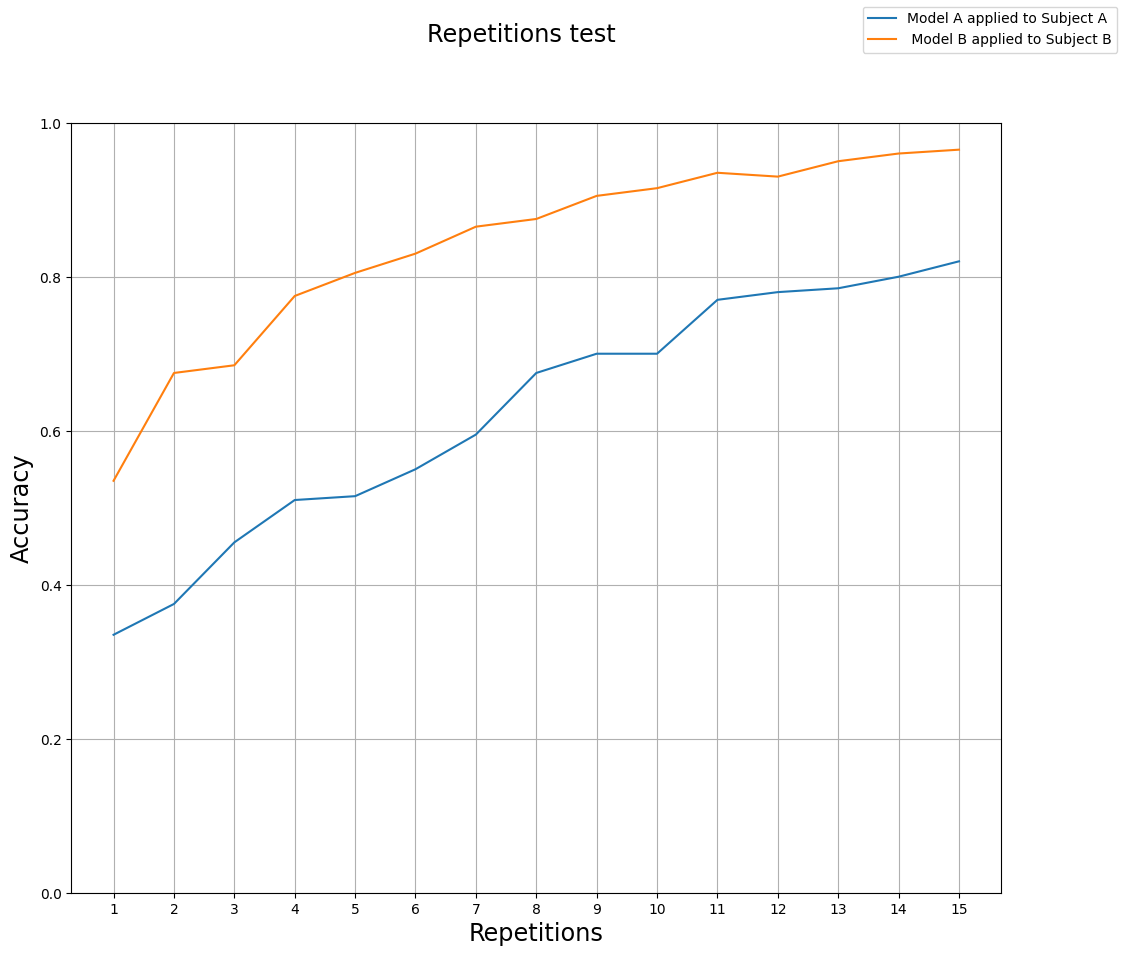

In [70]:
t = range(1,16)
fig = plt.figure(figsize=(12,10))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.plot(t, accuracy_A, t, accuracy_B)
plt.xlabel('Repetitions', size='xx-large')
plt.xticks(t)
plt.ylabel('Accuracy', size='xx-large')
fig.suptitle('Repetitions test', size='xx-large')
fig.legend(['Model A applied to Subject A',' Model B applied to Subject B'])
plt.show()
     

Dùng Model A dự đoán EEG của Model B

In [71]:
predictions_B_on_A = modelB.predict(epochs_A_TEST_reshaped)
binary_predictions_B_on_A = binary_pred(predictions_B_on_A, 0.5)
stat(target_B_TEST, binary_predictions_B_on_A,'B on A')

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
sensitivity on test B on A :
 0.20733333333333334
specificity on test: B on A :
 0.8042
accuracy on test: B on A :
 0.7047222222222222
PPV on test B on A :
 0.1747681933127283
NPV on test B on A :
 0.8353299632989405


In [72]:
_,accuracy_BA,_ = speller(predictions_B_on_A, epochsB, word_B)

**********************************
          RESULTS          
**********************************
Number of repetitions: 15
Accuracy of rows and columns classification: [0.185 0.17  0.195 0.18  0.155 0.16  0.155 0.185 0.175 0.17  0.165 0.15
 0.175 0.18  0.18 ]
Accuracy of letters classification: [0.07 0.02 0.01 0.01 0.   0.01 0.02 0.02 0.03 0.02 0.03 0.01 0.03 0.06
 0.05]
final word:  ['Y', 'I', 'Z', 'F', 'G', '4', '9', '9', '2', '3', 'H', 'L', 'Y', 'D', 'X', '2', 'H', '3', 'O', 'R', 'T', 'G', '5', 'X', 'U', 'G', '9', 'E', 'X', '6', '_', 'U', '2', 'J', 'F', 'V', 'U', 'N', 'I', '3', '7', 'X', 'D', '4', 'I', 'I', '_', 'T', 'J', 'F', '3', '5', 'A', 'B', 'K', 'M', '1', 'K', 'V', 'E', '6', 'T', 'C', 'S', '3', 'L', 'S', 'Z', 'U', 'P', '9', '7', 'G', '1', 'Z', 'Q', 'L', 'I', 'M', 'S', '3', '8', 'V', 'S', '6', 'O', '9', 'J', 'X', '7', 'F', 'H', 'J', 'Z', '4', 'P', 'V', 'J', 'O', 'E']
real word:  ['M', 'E', 'R', 'M', 'I', 'R', 'O', 'O', 'M', 'U', 'H', 'J', 'P', 'X', 'J', 'O', 'H', 'U', 'V', 'L'

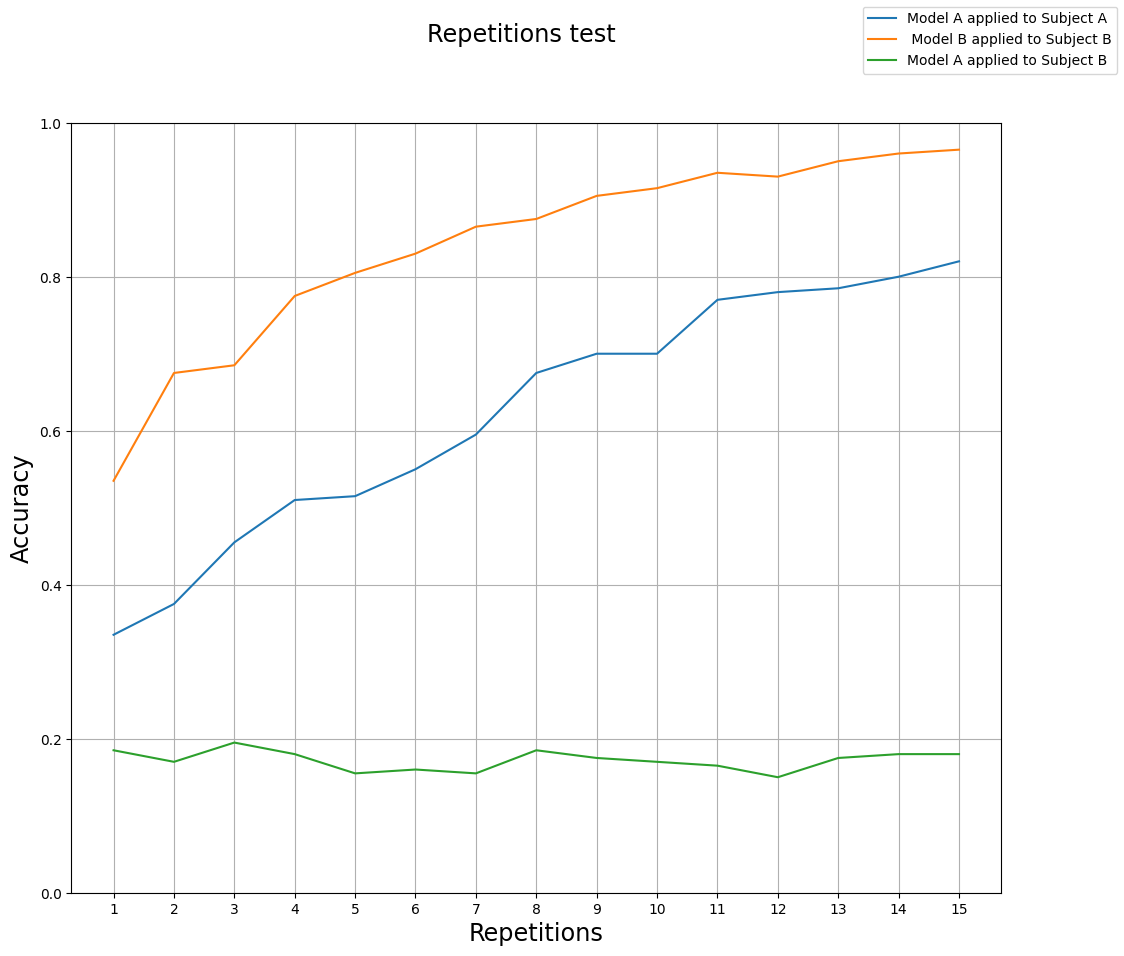

In [73]:
t = range(1,16)
fig = plt.figure(figsize=(12,10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.plot(t, accuracy_A, t, accuracy_B, t, accuracy_BA)
plt.xlabel('Repetitions', size='xx-large')
plt.xticks(t)
plt.ylabel('Accuracy', size='xx-large')
fig.suptitle('Repetitions test', size='xx-large')
fig.legend(['Model A applied to Subject A',' Model B applied to Subject B', 'Model A applied to Subject B'])
plt.show()

Tạo Model AB (đào tạo A và B cùng lúc)

In [79]:
epochs_AB_TRAIN_reshaped=np.concatenate((epochs_A_TRAIN_reshaped,epochs_B_TRAIN_reshaped))
epochs_AB_TEST_reshaped=np.concatenate((epochs_A_TEST_reshaped,epochs_B_TEST_reshaped))
target_AB_TRAIN=np.concatenate((target_A_TRAIN,target_B_TRAIN))
target_AB_TEST=np.concatenate((target_A_TEST,target_B_TEST))
stimulusCode_AB=np.concatenate((stimulusCode_A,stimulusCode_B))

In [ ]:

def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


modelAB = keras.models.Sequential([
        keras.layers.Conv3D(filters=32, input_shape=[24, 10, 11, 1], kernel_size = [3,2,2], strides=(2,1,1),activation = 'elu', padding="SAME", 
                            kernel_regularizer= keras.regularizers.l2(0.02)),
                            
        keras.layers.Conv3D(filters=64, kernel_size = [2,2,2], strides=(2,1,1),activation = 'elu', padding="SAME",
                            kernel_regularizer= keras.regularizers.l2(0.02)),

        keras.layers.MaxPool3D(pool_size=(1,3,3)),
        keras.layers.BatchNormalization(), # normalizing the batch

        keras.layers.Flatten(),
        keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(0.02)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(0.02)),
        keras.layers.Dropout(0.4),

        keras.layers.Dense(units=1, activation='softmax')                                 
])

c:\Users\LOQ\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
modelAB.compile(loss='binary_crossentropy', 
               optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
               metrics=['accuracy'])
class_weight = {0: 1.,1: 1.}

In [80]:
historyAB = modelAB.fit(epochs_AB_TRAIN_reshaped, target_AB_TRAIN, epochs=10, batch_size=32, class_weight = class_weight,
                    validation_data =(epochs_AB_TEST_reshaped,target_AB_TEST))

Epoch 1/10


c:\Users\LOQ\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


956/957 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1690 - loss: 2.8842

c:\Users\LOQ\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


957/957 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.1690 - loss: 2.8809 - val_accuracy: 0.1667 - val_loss: 0.4574
Epoch 2/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.1671 - loss: 0.4586 - val_accuracy: 0.1667 - val_loss: 0.4553
Epoch 3/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.1692 - loss: 0.4642 - val_accuracy: 0.1667 - val_loss: 0.4519
Epoch 4/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.1664 - loss: 0.4514 - val_accuracy: 0.1667 - val_loss: 0.4522
Epoch 5/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.1676 - loss: 0.4540 - val_accuracy: 0.1667 - val_loss: 0.4507
Epoch 6/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.1697 - loss: 0.4556 - val_accuracy: 0.1667 - val_loss: 0.4514
Epoch 7/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.1654 - loss: 0.4496 - val_accuracy: 0.1667 - val_loss: 0.4511
Epoch 8/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.1642 - loss: 0.4477 - val_accurac

In [81]:
word_AB=word_A+word_B
epochsAB , word = preSpeller(stimulusCode_AB, word_AB)
predictions_AB = modelAB.predict(epochs_AB_TEST_reshaped)
binary_predictions_AB = binary_pred(predictions_AB, 0.5)
stat(target_AB_TEST, binary_predictions_AB,'AB')

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
sensitivity on test AB :
 1.0
specificity on test: AB :
 0.0
accuracy on test: AB :
 0.16666666666666666
PPV on test AB :
 0.16666666666666666
NPV on test AB :
 nan


C:\Users\LOQ\AppData\Local\Temp\ipykernel_9780\1313741117.py:22: RuntimeWarning: invalid value encountered in scalar divide
  NPV = TN / (TN + FN)


Kết quả dự đoán AB

In [82]:
target_word_AB,accuracy_AB,accuracy_let_AB = speller(predictions_AB, epochsAB, word_AB)

**********************************
          RESULTS          
**********************************
Number of repetitions: 15
Accuracy of rows and columns classification: [0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19]
Accuracy of letters classification: [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03]
final word:  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 